## Import some python packages

In [1]:
%matplotlib inline
import pickle
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.models import load_model  # For loading the trained model
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Load the data

In [2]:
Xd = pickle.load(open("data/RML2016.10a_dict.pkl",'rb'),encoding = "bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

## Split the data into training and test sets

In [3]:
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2

train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))

X_train = X[train_idx]
X_test = X[test_idx]

## Convert the dependent variables (labels) into one-hoe encoding format

In [4]:
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)

lbl_encoded = lb.transform(np.asarray(lbl)[:,0])
y_train = lbl_encoded[train_idx]
y_test = lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [5]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


## Load the ANN and CNN models

In [29]:
model_ANN = load_model('model/ANN_model.h5')

In [30]:
model_CNN = load_model('model/CNN_model.h5')

## Build the ANN model

#### If you have already loaded the model in the `Load the ANN and CNN models` section, please feel free to skip this step

In [8]:
model_ANN = models.Sequential()

model_ANN.add(Dense(128, activation ='relu', input_shape = in_shp))

model_ANN.add(Dense(256, activation ='relu'))

model_ANN.add(Dense(128, activation = 'relu'))

model_ANN.add(Flatten())

model_ANN.add(Dense(128, activation = 'relu'))

model_ANN.add(Dense(len(classes), activation = 'softmax'))

model_ANN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 128)            16512     
_________________________________________________________________
dense_1 (Dense)              (None, 2, 256)            33024     
_________________________________________________________________
dense_2 (Dense)              (None, 2, 128)            32896     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1419      
Total params: 116,747
Trainable params: 116,747
Non-trainable params: 0
__________________________________________________

In [9]:
model_ANN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Train the ANN model

#### If you have already loaded the model in the `Load the ANN and CNN models` section, please feel free to skip this step

In [10]:
tic_ANN = time.time()
history_ANN = model_ANN.fit(X_train, y_train, batch_size = 1024, epochs = 100, verbose = 1, validation_data = (X_test, y_test), 
                            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1, 
                                                       mode = 'auto', restore_best_weights = True)])
toc_ANN = time.time()

Epoch 1/100
108/108 [==============================] - 28s 140ms/step - loss: 2.3044 - accuracy: 0.1532 - val_loss: 2.1329 - val_accuracy: 0.2026
Epoch 2/100
108/108 [==============================] - 4s 33ms/step - loss: 2.0926 - accuracy: 0.2175 - val_loss: 1.8800 - val_accuracy: 0.3010
Epoch 3/100
108/108 [==============================] - 3s 31ms/step - loss: 1.8248 - accuracy: 0.3140 - val_loss: 1.7159 - val_accuracy: 0.3430
Epoch 4/100
108/108 [==============================] - 4s 33ms/step - loss: 1.6913 - accuracy: 0.3515 - val_loss: 1.6584 - val_accuracy: 0.3627
Epoch 5/100
108/108 [==============================] - 4s 34ms/step - loss: 1.6385 - accuracy: 0.3700 - val_loss: 1.6270 - val_accuracy: 0.3684
Epoch 6/100
108/108 [==============================] - 4s 37ms/step - loss: 1.6082 - accuracy: 0.3784 - val_loss: 1.5993 - val_accuracy: 0.3836
Epoch 7/100
108/108 [==============================] - 4s 35ms/step - loss: 1.5844 - accuracy: 0.3891 - val_loss: 1.5825 - val_accurac

## Save the ANN model

#### If you have already loaded the model in the `Load the ANN and CNN models` section, please feel free to skip this step

In [11]:
model_ANN.save('model/ANN_model.h5')

## Build the CNN model

#### If you have already loaded the model in the `Load the ANN and CNN models` section, please feel free to skip this step

In [12]:
model_CNN = models.Sequential()

model_CNN.add(Reshape(in_shp + [1], input_shape = in_shp))

model_CNN.add(Conv2D(64, (1, 16), activation ='relu'))
model_CNN.add(Dropout(0.5))

model_CNN.add(Conv2D(32, (2, 8), activation ='relu'))
model_CNN.add(Dropout(0.5))

model_CNN.add(Conv2D(16, (1, 4), activation ='relu'))
model_CNN.add(Dropout(0.5))

model_CNN.add(Flatten())

model_CNN.add(Dense(512, activation ='relu'))
model_CNN.add(Dropout(0.5))

model_CNN.add(Dense(128, activation ='relu'))
model_CNN.add(Dropout(0.5))

model_CNN.add(Dense(len(classes), activation ='softmax'))

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 113, 64)        1088      
_________________________________________________________________
dropout (Dropout)            (None, 2, 113, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 106, 32)        32800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 106, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 103, 16)        2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 103, 16)       

In [13]:
model_CNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Train the CNN model

#### If you have already loaded the model in the `Load the ANN and CNN models` section, please feel free to skip this step

In [14]:
tic_CNN = time.time()
history_CNN = model_CNN.fit(X_train, y_train, batch_size = 1024, epochs = 100, verbose = 1, validation_data = (X_test, y_test),
                            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1, 
                                                       mode = 'auto', restore_best_weights = True)])
toc_CNN = time.time()

Epoch 1/100
108/108 [==============================] - 143s 1s/step - loss: 2.3520 - accuracy: 0.1135 - val_loss: 2.1474 - val_accuracy: 0.2063
Epoch 2/100
108/108 [==============================] - 141s 1s/step - loss: 2.0967 - accuracy: 0.2045 - val_loss: 1.8381 - val_accuracy: 0.3148
Epoch 3/100
108/108 [==============================] - 137s 1s/step - loss: 1.8199 - accuracy: 0.3105 - val_loss: 1.6607 - val_accuracy: 0.3625
Epoch 4/100
108/108 [==============================] - 139s 1s/step - loss: 1.6510 - accuracy: 0.3670 - val_loss: 1.4927 - val_accuracy: 0.4325
Epoch 5/100
108/108 [==============================] - 144s 1s/step - loss: 1.5122 - accuracy: 0.4267 - val_loss: 1.4222 - val_accuracy: 0.4424
Epoch 6/100
108/108 [==============================] - 139s 1s/step - loss: 1.4455 - accuracy: 0.4465 - val_loss: 1.3617 - val_accuracy: 0.4713
Epoch 7/100
108/108 [==============================] - 138s 1s/step - loss: 1.4031 - accuracy: 0.4590 - val_loss: 1.3395 - val_accuracy:

## Save the CNN model

#### If you have already loaded the model in the `Load the ANN and CNN models` section, please feel free to skip this step

In [15]:
model_CNN.save('model/CNN_model.h5')

## Compare the training time

#### If you have not trained the models, you may not get the reuslt in this section

In [16]:
training_time_ANN = toc_ANN - tic_ANN
training_time_CNN = toc_CNN - tic_CNN

print ("The training time for ANN is %.3f seconds" %(training_time_ANN))
print ("The training time for CNN is %.3f seconds" %(training_time_CNN))

The training time for ANN is 281.324 seconds
The training time for CNN is 12741.907 seconds


## Compare test loss and accuracy

In [31]:
score_ANN = model_ANN.evaluate(X_test, y_test)

3438/3438 [==============================] - 6s 2ms/step - loss: 1.4437 - accuracy: 0.4455


In [32]:
score_CNN = model_CNN.evaluate(X_test, y_test)

3438/3438 [==============================] - 33s 9ms/step - loss: 1.1487 - accuracy: 0.5560


In [33]:
print('Test loss of ANN:', score_ANN[0])
print('Test accuracy of ANN:', score_ANN[1])
print()
print('Test loss of CNN:', score_CNN[0])
print('Test accuracy of CNN:', score_CNN[1])

Test loss of ANN: 1.443664312362671
Test accuracy of ANN: 0.44545453786849976

Test loss of CNN: 1.148657202720642
Test accuracy of CNN: 0.5559909343719482


## Show classification report

In [17]:
y_predict_ANN = model_ANN.predict(X_test)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_ANN, axis = 1)))

              precision    recall  f1-score   support

           0       0.29      0.23      0.26      9991
           1       0.59      0.46      0.52     10041
           2       0.27      0.89      0.42      9915
           3       0.52      0.44      0.48      9841
           4       0.66      0.58      0.61     10076
           5       0.80      0.63      0.71     10067
           6       0.76      0.49      0.60     10086
           7       0.29      0.33      0.31     10024
           8       0.47      0.18      0.26      9920
           9       0.31      0.19      0.24      9998
          10       0.54      0.48      0.51     10041

    accuracy                           0.45    110000
   macro avg       0.50      0.45      0.45    110000
weighted avg       0.50      0.45      0.45    110000



In [18]:
y_predict_CNN = model_CNN.predict(X_test)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_CNN, axis = 1)))

              precision    recall  f1-score   support

           0       0.73      0.54      0.62      9991
           1       0.51      0.67      0.58     10041
           2       0.26      0.93      0.41      9915
           3       0.89      0.58      0.71      9841
           4       0.73      0.65      0.69     10076
           5       0.83      0.63      0.72     10067
           6       0.91      0.68      0.78     10086
           7       0.34      0.04      0.08     10024
           8       0.51      0.71      0.59      9920
           9       0.82      0.53      0.65      9998
          10       0.65      0.16      0.25     10041

    accuracy                           0.56    110000
   macro avg       0.65      0.56      0.55    110000
weighted avg       0.65      0.56      0.55    110000



## Show loss curves 

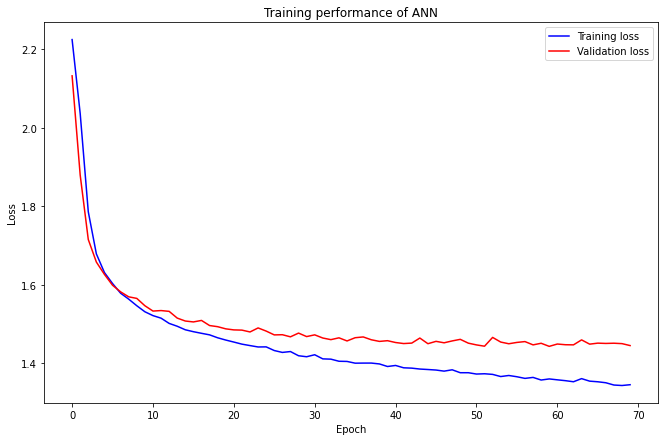

In [19]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of ANN')
plt.plot(history_ANN.epoch, history_ANN.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_ANN.epoch, history_ANN.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/ANN_loss_curve.png')
plt.show()

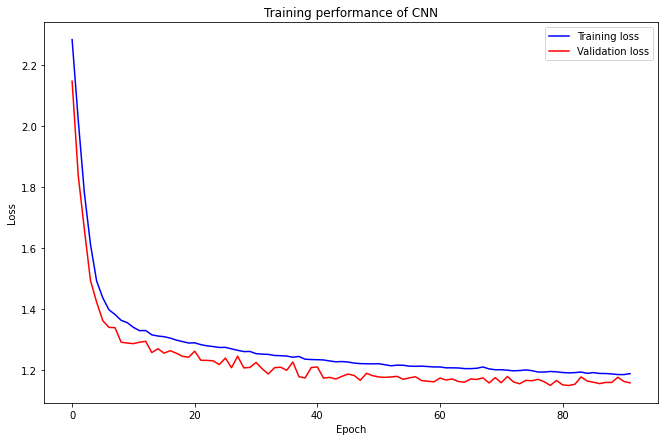

In [20]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of CNN')
plt.plot(history_CNN.epoch, history_CNN.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_CNN.epoch, history_CNN.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/CNN_loss_curve.png')
plt.show()

## Plot confusion matrix

In [21]:
def plot_confusion_matrix(cm, title, cmap = plt.cm.Blues, labels = []):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation = 45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
def confusion_matrix(model, classes, X_test, y_test, title):
    test_Y_hat = model.predict(X_test, batch_size = 1024)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])

    for i in range(0, X_test.shape[0]):
        j = list(y_test[i,:]).index(1)
        k = int(np.argmax(test_Y_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    plot_confusion_matrix(confnorm, title, labels = classes)

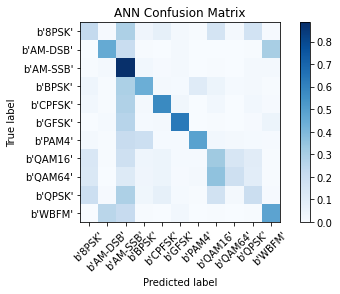

In [23]:
confusion_matrix(model_ANN, classes, X_test, y_test, 'ANN Confusion Matrix')

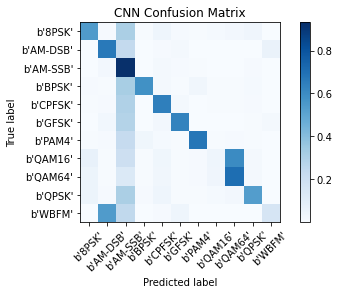

In [24]:
confusion_matrix(model_CNN, classes, X_test, y_test, 'CNN Confusion Matrix')

## Get the test accuracy for different SNRs

In [25]:
def getTestAccArray(model, lbl, X_test, y_test, test_idx, model_name):
    acc = []
    
    snr_array=np.asarray(lbl)[:,1]
    lb_temp = preprocessing.LabelBinarizer()
    lb_temp.fit(snr_array)
    temp_array=lb_temp.classes_
    snr_label_array = []
    test_SNRs=snr_array[test_idx]

    snr_label_array.append(temp_array[6])
    snr_label_array.append(temp_array[4])
    snr_label_array.append(temp_array[3])
    snr_label_array.append(temp_array[2])
    snr_label_array.append(temp_array[1])
    snr_label_array.append(temp_array[0])
    snr_label_array.append(temp_array[9])
    snr_label_array.append(temp_array[8])
    snr_label_array.append(temp_array[7])
    snr_label_array.append(temp_array[5])
    snr_label_array.append(temp_array[10])
    snr_label_array.append(temp_array[16])
    snr_label_array.append(temp_array[17])
    snr_label_array.append(temp_array[18])
    snr_label_array.append(temp_array[19])
    snr_label_array.append(temp_array[11])
    snr_label_array.append(temp_array[12])
    snr_label_array.append(temp_array[13])
    snr_label_array.append(temp_array[14])
    snr_label_array.append(temp_array[15])

    for snr in snr_label_array:
        test_X_i = X_test[np.where(test_SNRs==snr)]
        test_Y_i = y_test[np.where(test_SNRs==snr)]

        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes), len(classes)])
        confnorm = np.zeros([len(classes), len(classes)])
        
        for i in range(0, test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
            
        for i in range(0, len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

        plt.figure()
        SNR_value = snr.astype('int')
        plot_confusion_matrix(confnorm, labels=classes, 
                              title="{model_name} Confusion Matrix (SNR={SNR_value})".format(model_name=model_name, SNR_value=SNR_value))

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
        acc.append(1.0*cor/(cor+ncor))
        
    return acc

Confusion matrix of ANN for different SNRs
Overall Accuracy:  0.09123563218390805 for SNR b'-20'
Overall Accuracy:  0.09782807081584231 for SNR b'-18'
Overall Accuracy:  0.0998918139199423 for SNR b'-16'
Overall Accuracy:  0.11009509875640087 for SNR b'-14'
Overall Accuracy:  0.1419124218051832 for SNR b'-12'
Overall Accuracy:  0.2218135000919625 for SNR b'-10'
Overall Accuracy:  0.31749260355029585 for SNR b'-8'
Overall Accuracy:  0.3455143431390462 for SNR b'-6'
Overall Accuracy:  0.39888849049838654 for SNR b'-4'
Overall Accuracy:  0.5477487291212781 for SNR b'-2'
Overall Accuracy:  0.6380007350238883 for SNR b'0'
Overall Accuracy:  0.6694484760522497 for SNR b'2'
Overall Accuracy:  0.6552607502287283 for SNR b'4'
Overall Accuracy:  0.6637314254265272 for SNR b'6'
Overall Accuracy:  0.6398777418194894 for SNR b'8'
Overall Accuracy:  0.6579462537818117 for SNR b'10'
Overall Accuracy:  0.6515565264882578 for SNR b'12'
Overall Accuracy:  0.6607825295723385 for SNR b'14'
Overall Accurac

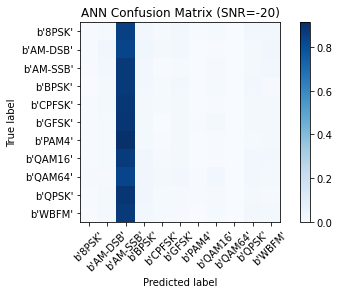

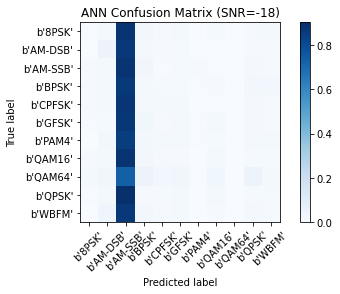

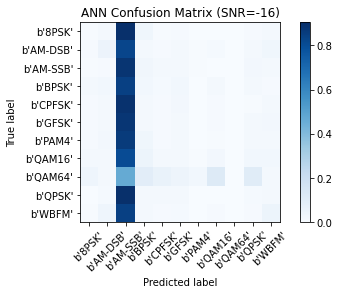

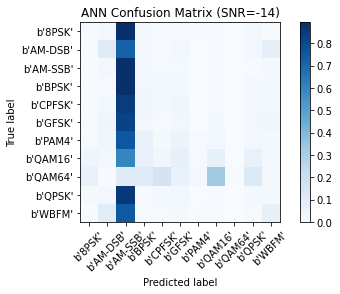

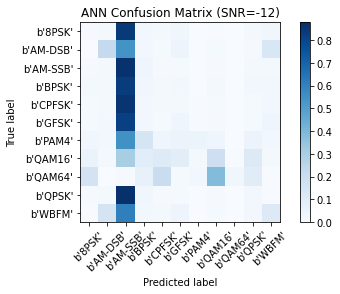

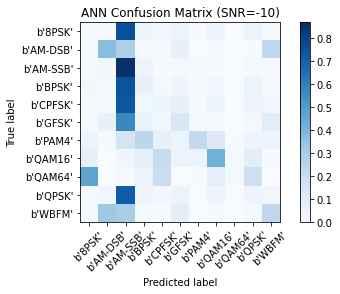

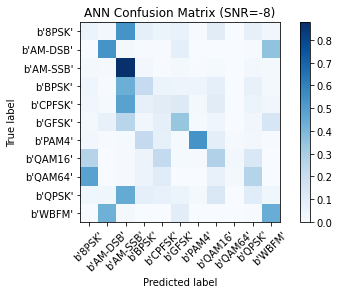

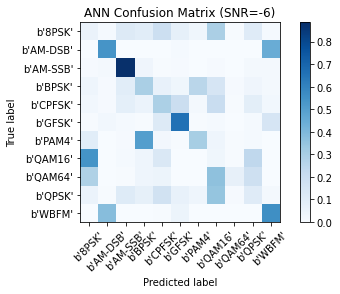

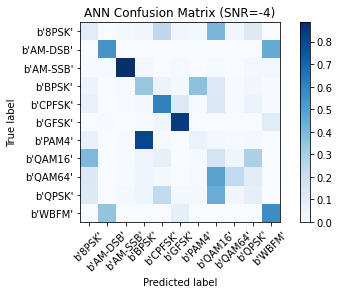

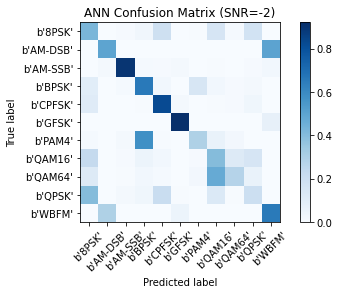

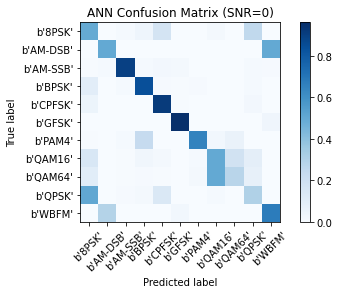

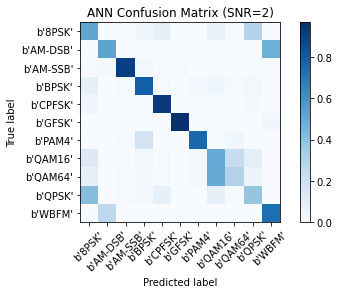

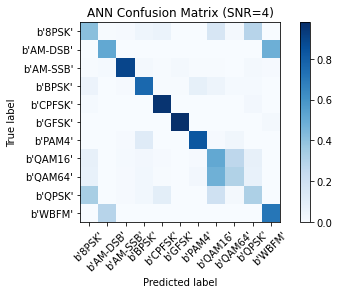

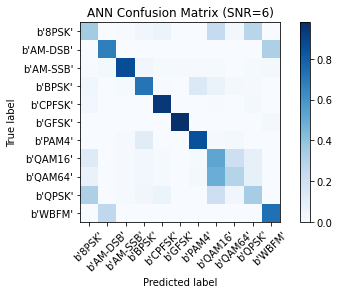

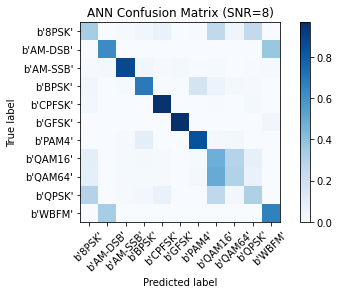

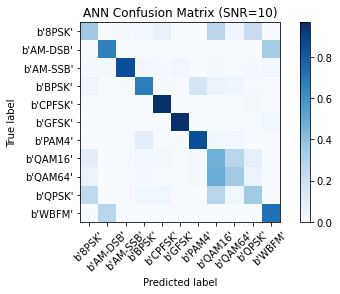

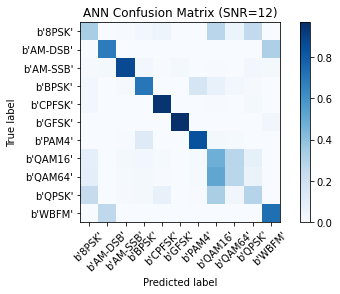

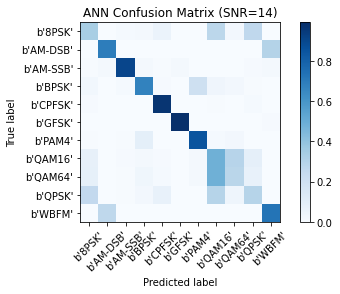

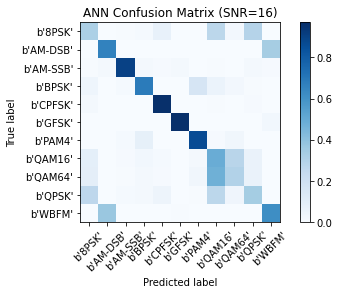

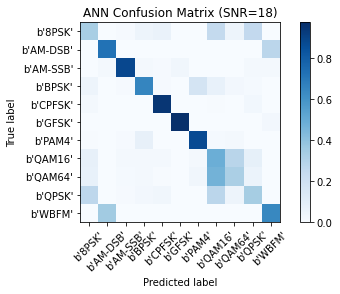

In [26]:
print('Confusion matrix of ANN for different SNRs')
acc_ANN = getTestAccArray(model_ANN, lbl, X_test, y_test, test_idx, 'ANN')

Confusion matrix of CNN for different SNRs
Overall Accuracy:  0.0908764367816092 for SNR b'-20'
Overall Accuracy:  0.09527286001095091 for SNR b'-18'
Overall Accuracy:  0.09826902271907681 for SNR b'-16'
Overall Accuracy:  0.11046086320409657 for SNR b'-14'
Overall Accuracy:  0.15352993744414656 for SNR b'-12'
Overall Accuracy:  0.251241493470664 for SNR b'-10'
Overall Accuracy:  0.3552144970414201 for SNR b'-8'
Overall Accuracy:  0.48693586698337293 for SNR b'-6'
Overall Accuracy:  0.6306920043026174 for SNR b'-4'
Overall Accuracy:  0.7287581699346405 for SNR b'-2'
Overall Accuracy:  0.7997059904446895 for SNR b'0'
Overall Accuracy:  0.8156748911465893 for SNR b'2'
Overall Accuracy:  0.8075022872827081 for SNR b'4'
Overall Accuracy:  0.8220509998165474 for SNR b'6'
Overall Accuracy:  0.8157137720244516 for SNR b'8'
Overall Accuracy:  0.809218722192561 for SNR b'10'
Overall Accuracy:  0.8070271254323684 for SNR b'12'
Overall Accuracy:  0.8247497725204732 for SNR b'14'
Overall Accuracy:

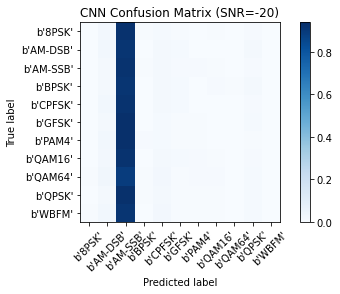

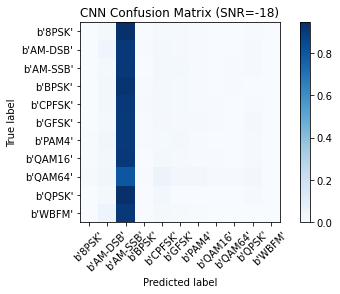

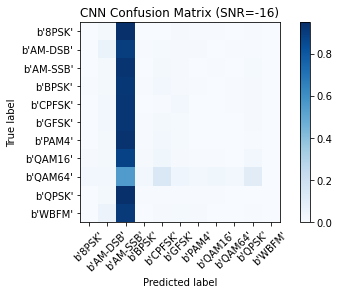

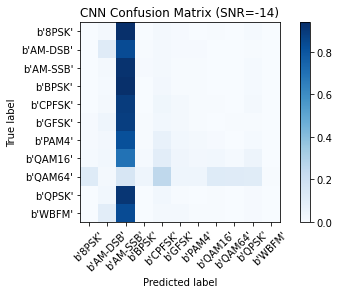

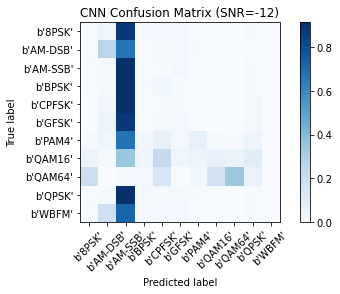

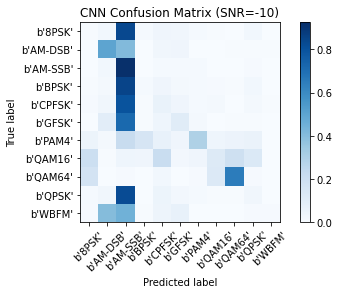

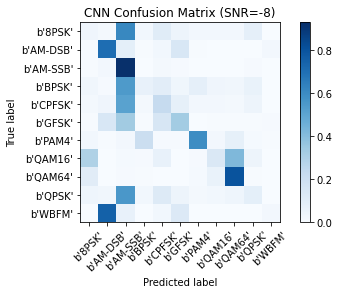

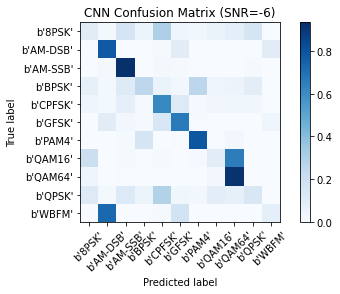

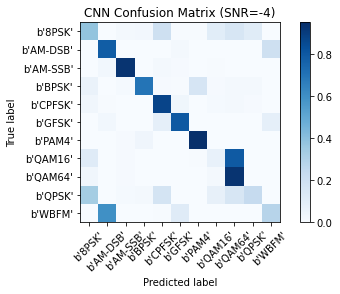

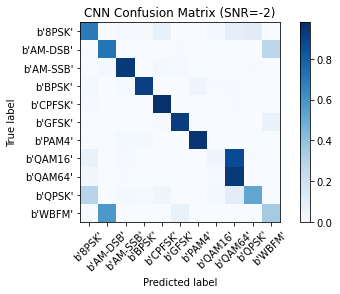

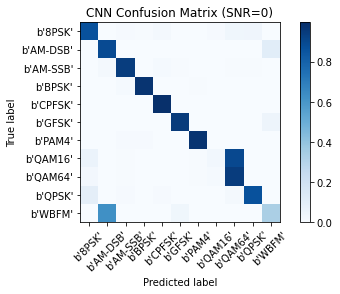

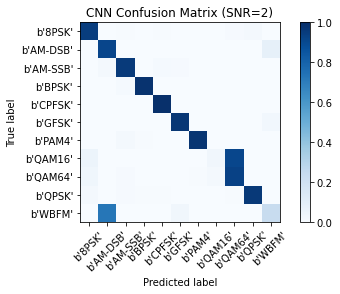

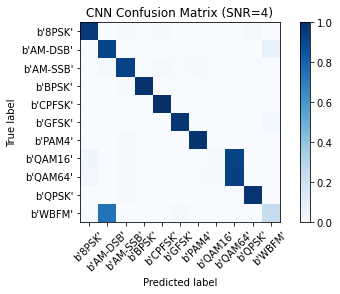

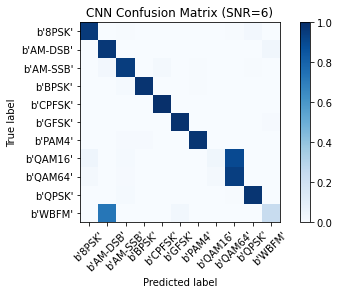

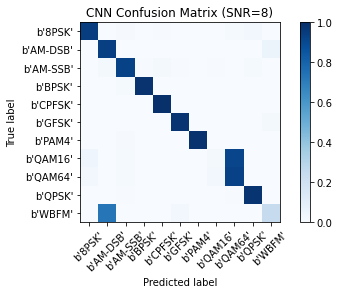

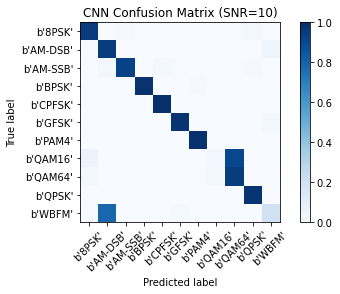

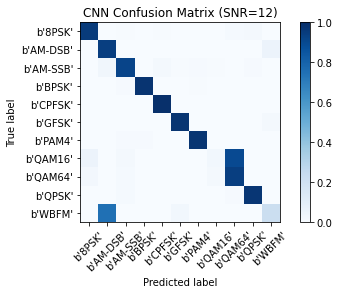

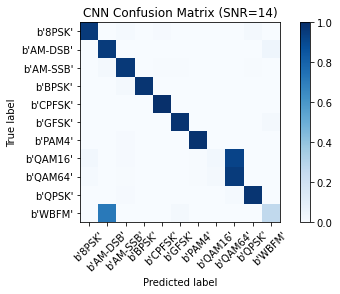

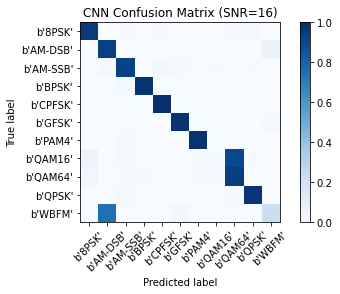

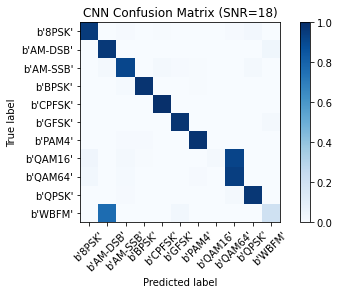

In [27]:
print('Confusion matrix of CNN for different SNRs')
acc_CNN = getTestAccArray(model_CNN, lbl, X_test, y_test, test_idx, 'CNN')

## Plot accuracy curves

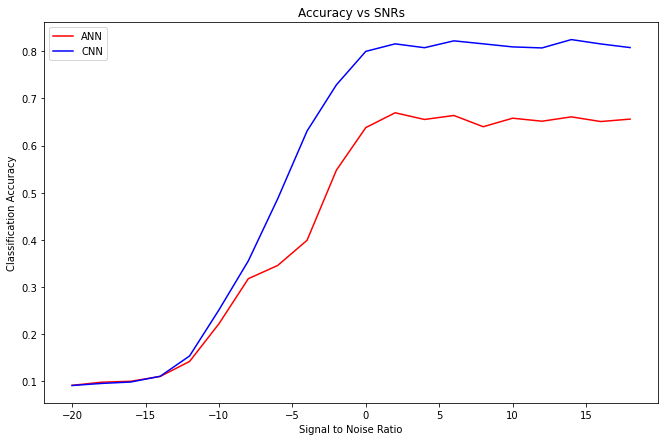

In [28]:
plt.figure(figsize = (11, 7))
plt.plot(snrs, acc_ANN, color= 'red', label= 'ANN')
plt.plot(snrs, acc_CNN, color= 'blue', label= 'CNN')
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title('Accuracy vs SNRs')
plt.legend()
plt.savefig('img/ANN_vs_CNN_result.png')
plt.show()